## Семинар: "Методы оптимизации"

In [ ]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [ ]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

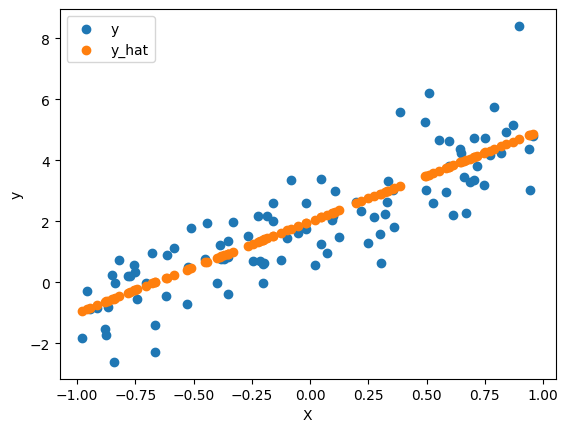

In [ ]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

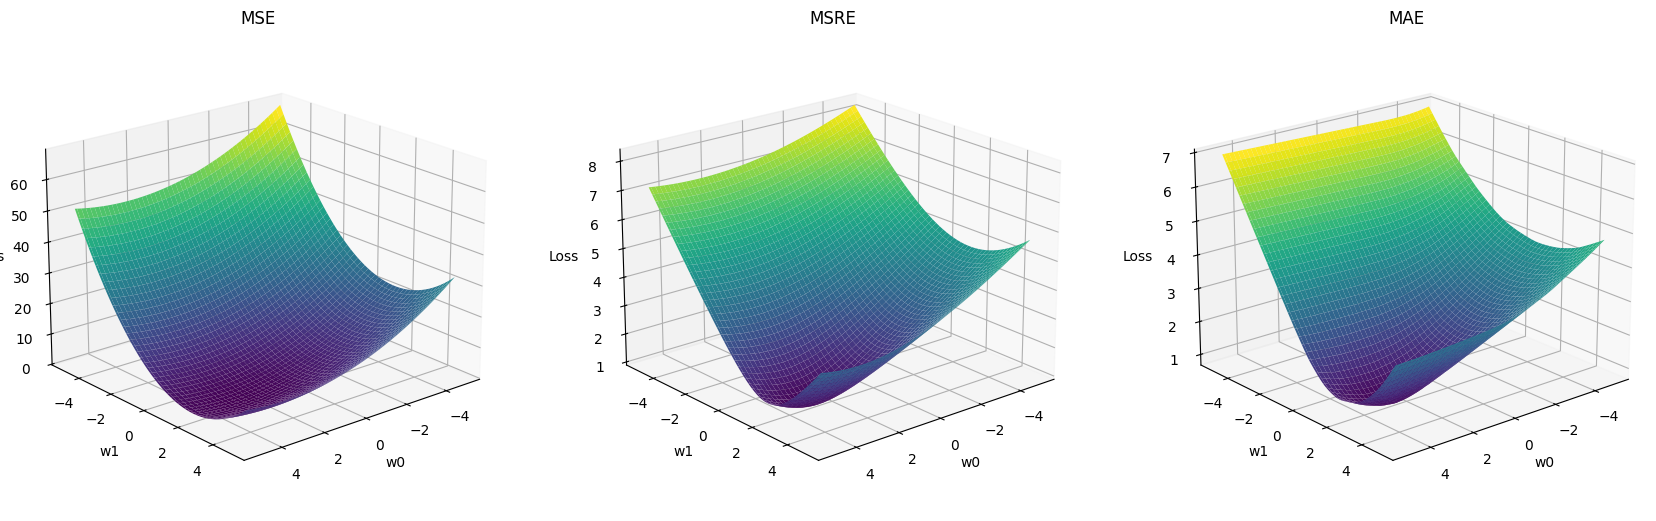

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [ ]:
class Optimizer:
    def __init__(self, params, lr=None):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [ ]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [ ]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [ ]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [ ]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [ ]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.lr = lr

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.lr * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [ ]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.lr / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [ ]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [ ]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'lr' : 1}],
        ['RMSProp', RMSProp, {'lr' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [ ]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2, betas=(0.9, 0.999)):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.betas = betas

        self.t = 0
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * p.grad
                self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * (p.grad ** 2)
                m_hat = self.m[i] / (1 - self.betas[0] ** self.t)
                v_hat = self.v[i] / (1 - self.betas[1] ** self.t)
                p -= self.lr * self.m[i] / (torch.sqrt(self.v[i]) + self.epsilon)

In [ ]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-3):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.betas = betas
        self.weight_decay = weight_decay

        self.t = 0
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            self.t += 1
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * p.grad
                self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * (p.grad ** 2)
                m_hat = self.m[i] / (1 - self.betas[0] ** self.t)
                v_hat = self.v[i] / (1 - self.betas[1] ** self.t)
                p -= self.lr * self.m[i] / (torch.sqrt(self.v[i]) + self.epsilon) - self.lr * self.weight_decay * p

Сравним Adam и AdamW с Momentum и RMSProp

In [ ]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['RMSProp', RMSProp, {'lr' : 1}],
        ['Adam', Adam, {'lr' : 1e-1, 'betas' : (0.9, 0.999)}],
        ['AdamW', AdamW, {'lr' : 1e-1, 'betas' : (0.9, 0.999), 'weight_decay' : 1e-2}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-09-28 15:59:38--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-09-28 15:59:38--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [          <=>       ]  33.20M  16.9MB/s    in 2.0s    

2025-09-28 15:59:40 (16.9 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [70]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [71]:
seed_everything(42)

In [72]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

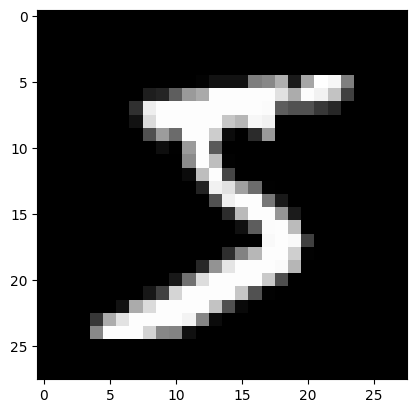

In [73]:
plt.imshow(train_dataset[0][0].squeeze(0).numpy().reshape([28, 28]), cmap='grey')
plt.show()

In [74]:
import torch.nn.functional as F

In [122]:
def train(model, optimizer, n_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    for epoch in range(n_epochs):

        # обучение
        print(f'Epoch: {epoch + 1}')
        train_loss = []
        train_accuracy = []
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.detach().numpy())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())

        print(f'train_loss: {np.mean(train_loss)}, train_accuracy: {np.mean(train_accuracy)}')
        train_loss_list.append(np.mean(train_loss))
        train_accuracy_list.append(np.mean(train_accuracy))

        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(test_loader):
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            val_loss_mean = np.mean(val_loss)
            val_accuracy_mean = np.mean(val_accuracy)
            print(f'val_loss: {val_loss_mean}, val_accuracy: {val_accuracy_mean}')
            print()
            val_loss_list.append(val_loss_mean)
            val_accuracy_list.append(val_accuracy_mean)

    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

Простая модель для классификации:

In [123]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = SGD(model.parameters(), lr=1e-1)

In [124]:
train_loss_list_SGD, val_loss_list_SGD, train_accuracy_list_SGD, val_accuracy_list_SGD = train(model, optimizer)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.201153963804245, train_accuracy: 0.9372833333333334


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.07815691083669662, val_accuracy: 0.9737

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.0653609111905098, train_accuracy: 0.9799833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.07601887732744217, val_accuracy: 0.9752

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.04869959503412247, train_accuracy: 0.98445


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.05695616453886032, val_accuracy: 0.9808

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.03825696185231209, train_accuracy: 0.9876666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.07220256328582764, val_accuracy: 0.9759

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.031832899898290634, train_accuracy: 0.9896


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.031797342002391815, val_accuracy: 0.9892



In [125]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [126]:
train_loss_list_Adam, val_loss_list_Adam, train_accuracy_list_Adam, val_accuracy_list_Adam = train(model, optimizer)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.13952411711215973, train_accuracy: 0.9568333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.061509933322668076, val_accuracy: 0.9808

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.05681415647268295, train_accuracy: 0.98285


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04461165517568588, val_accuracy: 0.9862

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.04379335790872574, train_accuracy: 0.9857333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04434540495276451, val_accuracy: 0.9863

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.03505482152104378, train_accuracy: 0.9886833333333334


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04149120673537254, val_accuracy: 0.9865

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.030147332698106766, train_accuracy: 0.9904


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03987150266766548, val_accuracy: 0.9879



In [127]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2)

In [128]:
train_loss_list_AdamW, val_loss_list_AdamW, train_accuracy_list_AdamW, val_accuracy_list_AdamW = train(model, optimizer)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.13943856954574585, train_accuracy: 0.9570666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.0557427816092968, val_accuracy: 0.9832

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.05694784224033356, train_accuracy: 0.9821833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.044507987797260284, val_accuracy: 0.9859

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.04343100264668465, train_accuracy: 0.9860166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04991767928004265, val_accuracy: 0.9832

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.035313863307237625, train_accuracy: 0.98875


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03830866143107414, val_accuracy: 0.9874

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.030571969226002693, train_accuracy: 0.9902833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04249387979507446, val_accuracy: 0.987



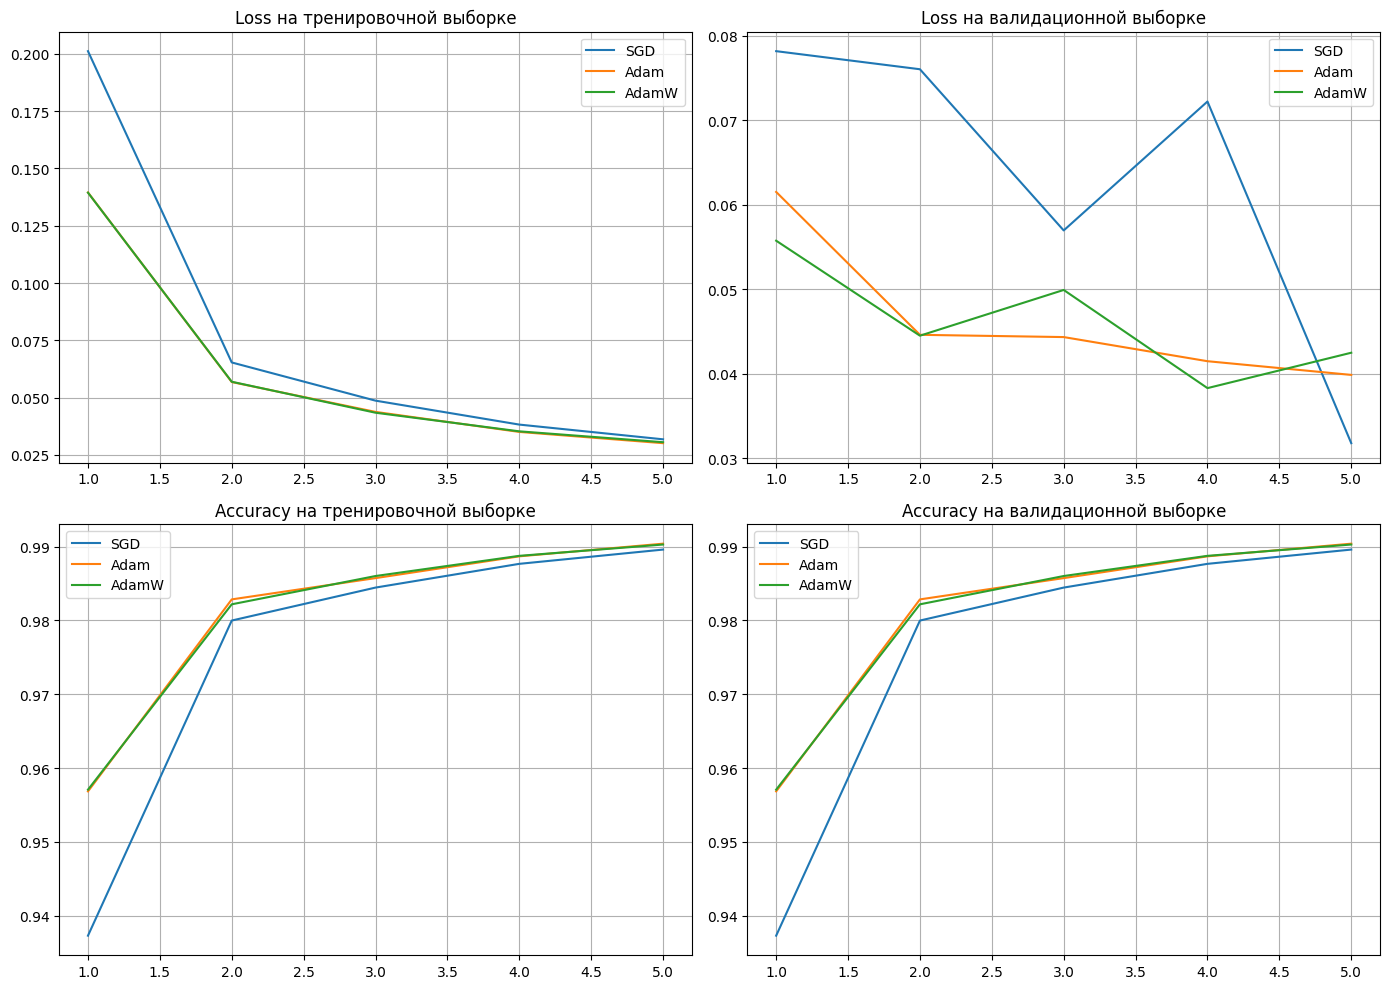

In [129]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = np.arange(1, 5 + 1)

axes[0][0].plot(epochs, train_loss_list_SGD, label='SGD')
axes[0][0].plot(epochs, train_loss_list_Adam, label='Adam')
axes[0][0].plot(epochs, train_loss_list_AdamW, label='AdamW')
axes[0][0].set_title('Loss на тренировочной выборке')
axes[0][0].legend()
axes[0][0].grid()

axes[0][1].plot(epochs, val_loss_list_SGD, label='SGD')
axes[0][1].plot(epochs, val_loss_list_Adam, label='Adam')
axes[0][1].plot(epochs, val_loss_list_AdamW, label='AdamW')
axes[0][1].set_title('Loss на валидационной выборке')
axes[0][1].legend()
axes[0][1].grid()

axes[1][0].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][0].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][0].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][0].set_title('Accuracy на тренировочной выборке')
axes[1][0].legend()
axes[1][0].grid()

axes[1][1].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][1].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][1].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][1].set_title('Accuracy на валидационной выборке')
axes[1][1].legend()
axes[1][1].grid()

plt.tight_layout()
plt.show()

Вмдно, что Adam и AdamW сходятся быстрее, однако итоговая точность после пяти эпох обучения даже выше с SGD.

In [84]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [112]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.optimizer = optimizer
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

        self.iter_count = 0
        self.base_lr = optimizer.lr

    def step(self):
        if self.iter_count < self.total_iters:
            factor = self.start_factor + (self.end_factor - self.start_factor) * self.iter_count / self.total_iters
            self.optimizer.lr = self.base_lr * factor
        else:
            self.optimizer.lr = self.base_lr * self.end_factor

        self.iter_count += 1

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min

        self.iter_count = 0
        self.base_lr = optimizer.lr

    def step(self):
        if self.iter_count < self.T_max:
            factor = (1 + np.cos(np.pi * self.iter_count / self.T_max)) / 2
            self.optimizer.lr = self.base_lr * factor
        else:
            self.optimizer.lr = self.eta_min

        self.iter_count += 1

In [102]:
def train(model, optimizer, scheduler, n_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    for epoch in range(n_epochs):

        # обучение
        print(f'Epoch: {epoch + 1}')
        train_loss = []
        train_accuracy = []
        scheduler.step()
        for x_train, y_train in tqdm(train_loader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.detach().numpy())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).numpy().tolist())

        print(f'train_loss: {np.mean(train_loss)}, train_accuracy: {np.mean(train_accuracy)}')
        train_loss_list.append(np.mean(train_loss))
        train_accuracy_list.append(np.mean(train_accuracy))

        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(test_loader):
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            val_loss_mean = np.mean(val_loss)
            val_accuracy_mean = np.mean(val_accuracy)
            print(f'val_loss: {val_loss_mean}, val_accuracy: {val_accuracy_mean}')
            print()
            val_loss_list.append(val_loss_mean)
            val_accuracy_list.append(val_accuracy_mean)

    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

In [103]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = SGD(model.parameters(), lr=1e-1)
scheduler = LinearLR(optimizer, start_factor=1, end_factor=1e-2, total_iters=5)

In [104]:
train_loss_list_SGD, val_loss_list_SGD, train_accuracy_list_SGD, val_accuracy_list_SGD = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.2028941512107849, train_accuracy: 0.936


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.11895453184843063, val_accuracy: 0.9599

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.06247461214661598, train_accuracy: 0.9809


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.046639010310173035, val_accuracy: 0.9853

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.04458122327923775, train_accuracy: 0.98625


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04008550941944122, val_accuracy: 0.9867

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.0347612127661705, train_accuracy: 0.98985


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03817087784409523, val_accuracy: 0.9867

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.02862151525914669, train_accuracy: 0.9914833333333334


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03499254584312439, val_accuracy: 0.9884



In [105]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = LinearLR(optimizer, start_factor=1, end_factor=1e-2, total_iters=5)

In [106]:
train_loss_list_Adam, val_loss_list_Adam, train_accuracy_list_Adam, val_accuracy_list_Adam = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.13705678284168243, train_accuracy: 0.9568333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.06540904939174652, val_accuracy: 0.978

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.051468685269355774, train_accuracy: 0.9843


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.0454135499894619, val_accuracy: 0.9841

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.037880610674619675, train_accuracy: 0.9883166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.038911156356334686, val_accuracy: 0.9877

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.029191315174102783, train_accuracy: 0.9912166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03557921573519707, val_accuracy: 0.9881

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.023274580016732216, train_accuracy: 0.9932333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03581732138991356, val_accuracy: 0.9884



In [107]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = LinearLR(optimizer, start_factor=1, end_factor=1e-2, total_iters=5)

In [108]:
train_loss_list_AdamW, val_loss_list_AdamW, train_accuracy_list_AdamW, val_accuracy_list_AdamW = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.13666938245296478, train_accuracy: 0.95805


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.053600456565618515, val_accuracy: 0.9829

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.055003806948661804, train_accuracy: 0.9829166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.041528306901454926, val_accuracy: 0.987

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.03923029825091362, train_accuracy: 0.9878166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.0371265672147274, val_accuracy: 0.9877

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.030444862321019173, train_accuracy: 0.9912666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03520118072628975, val_accuracy: 0.9879

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.02479822188615799, train_accuracy: 0.99295


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.033760152757167816, val_accuracy: 0.9887



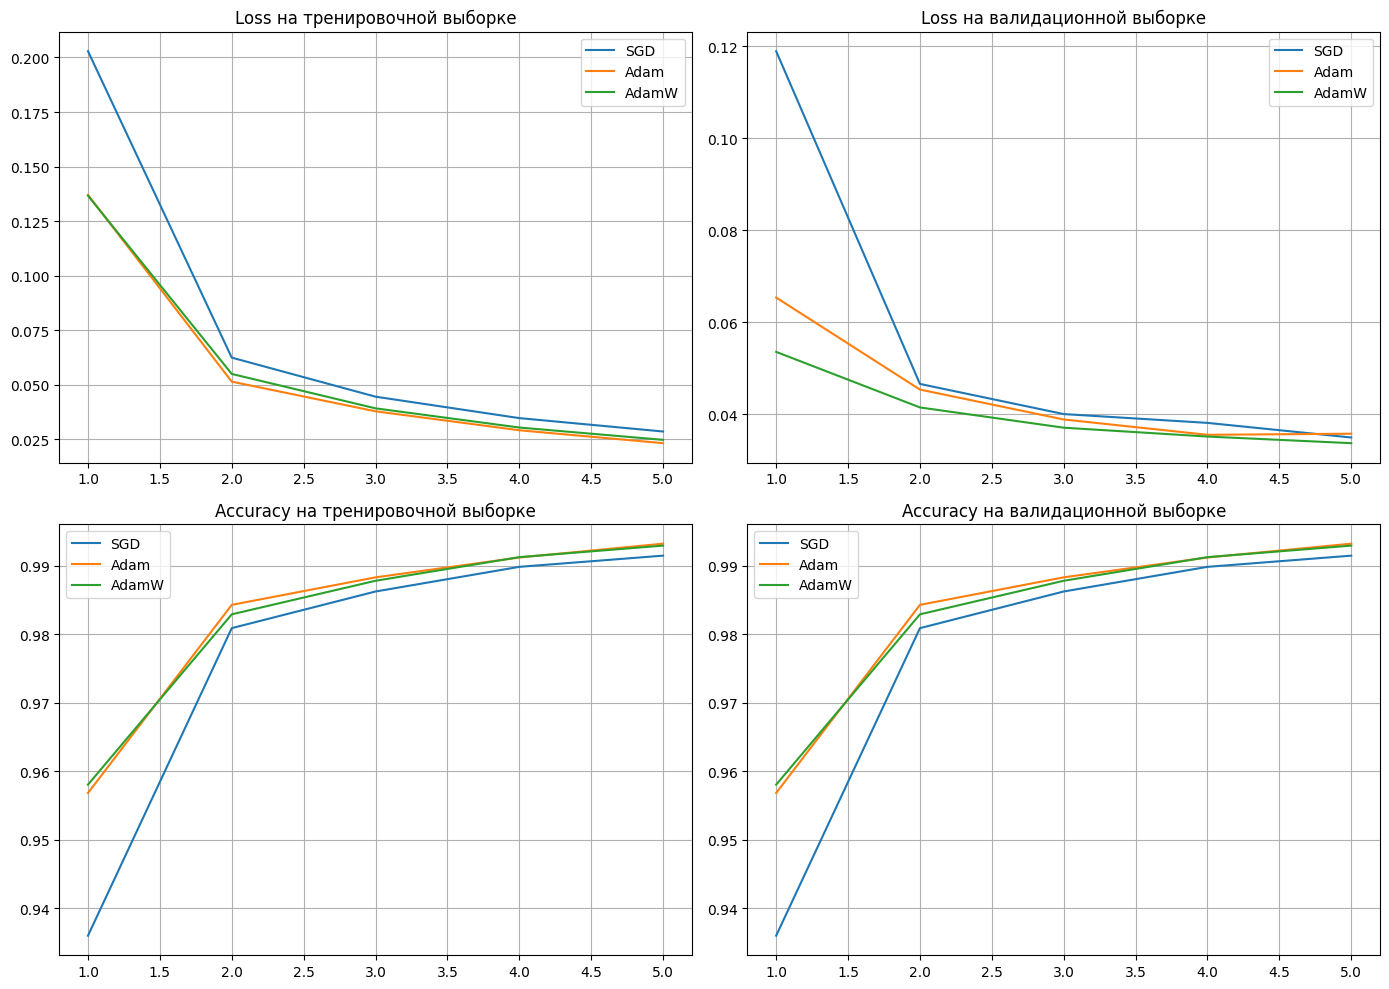

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = np.arange(1, 5 + 1)

axes[0][0].plot(epochs, train_loss_list_SGD, label='SGD')
axes[0][0].plot(epochs, train_loss_list_Adam, label='Adam')
axes[0][0].plot(epochs, train_loss_list_AdamW, label='AdamW')
axes[0][0].set_title('Loss на тренировочной выборке')
axes[0][0].legend()
axes[0][0].grid()

axes[0][1].plot(epochs, val_loss_list_SGD, label='SGD')
axes[0][1].plot(epochs, val_loss_list_Adam, label='Adam')
axes[0][1].plot(epochs, val_loss_list_AdamW, label='AdamW')
axes[0][1].set_title('Loss на валидационной выборке')
axes[0][1].legend()
axes[0][1].grid()

axes[1][0].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][0].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][0].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][0].set_title('Accuracy на тренировочной выборке')
axes[1][0].legend()
axes[1][0].grid()

axes[1][1].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][1].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][1].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][1].set_title('Accuracy на валидационной выборке')
axes[1][1].legend()
axes[1][1].grid()

plt.tight_layout()
plt.show()

Постеменное уменьшение learining_rate в теории должно позволять методу оптимизации сходится к локальному минимуму более точно. Значения loss на валидационной выборке для SGD, Adam и AdamW с фиксированным learning_rate (0.03200, 0.03987, 0.04249) улучшились для Adam'ов (0.03499, 0.03581, 0.03376), что дало незначительный прирост в точности.

In [113]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = SGD(model.parameters(), lr=1e-1)
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-2)

In [114]:
train_loss_list_SGD, val_loss_list_SGD, train_accuracy_list_SGD, val_accuracy_list_SGD = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.20320767164230347, train_accuracy: 0.9358


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.059992335736751556, val_accuracy: 0.9809

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.06496287882328033, train_accuracy: 0.9792833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.048344142735004425, val_accuracy: 0.9832

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.04348551481962204, train_accuracy: 0.9869666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.046465907245874405, val_accuracy: 0.9847

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.032622430473566055, train_accuracy: 0.9901833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03650965914130211, val_accuracy: 0.9885

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.02671896480023861, train_accuracy: 0.9925333333333334


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.032803017646074295, val_accuracy: 0.9893



In [115]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-2)

In [116]:
train_loss_list_Adam, val_loss_list_Adam, train_accuracy_list_Adam, val_accuracy_list_Adam = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.1451173573732376, train_accuracy: 0.9545666666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.06227372959256172, val_accuracy: 0.98

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.05345142260193825, train_accuracy: 0.9834166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04806674271821976, val_accuracy: 0.9856

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.03817471116781235, train_accuracy: 0.9881833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.045767493546009064, val_accuracy: 0.9852

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.028937557712197304, train_accuracy: 0.9911666666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.035169363021850586, val_accuracy: 0.9891

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.022691814228892326, train_accuracy: 0.9932833333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03440650925040245, val_accuracy: 0.9885



In [117]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # 24x24
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4), # 6x6
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = CosineAnnealing(optimizer, T_max=5, eta_min=1e-2)

In [118]:
train_loss_list_AdamW, val_loss_list_AdamW, train_accuracy_list_AdamW, val_accuracy_list_AdamW = train(model, optimizer, scheduler)

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.1400170922279358, train_accuracy: 0.9565166666666667


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.06061917170882225, val_accuracy: 0.9799

Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.055035099387168884, train_accuracy: 0.9832333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04698596149682999, val_accuracy: 0.9837

Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.03980013728141785, train_accuracy: 0.9882166666666666


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.04277654364705086, val_accuracy: 0.9863

Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.029897356405854225, train_accuracy: 0.9912


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03663996234536171, val_accuracy: 0.9884

Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]

train_loss: 0.024835780262947083, train_accuracy: 0.9929333333333333


  0%|          | 0/157 [00:00<?, ?it/s]

val_loss: 0.03222658857703209, val_accuracy: 0.99



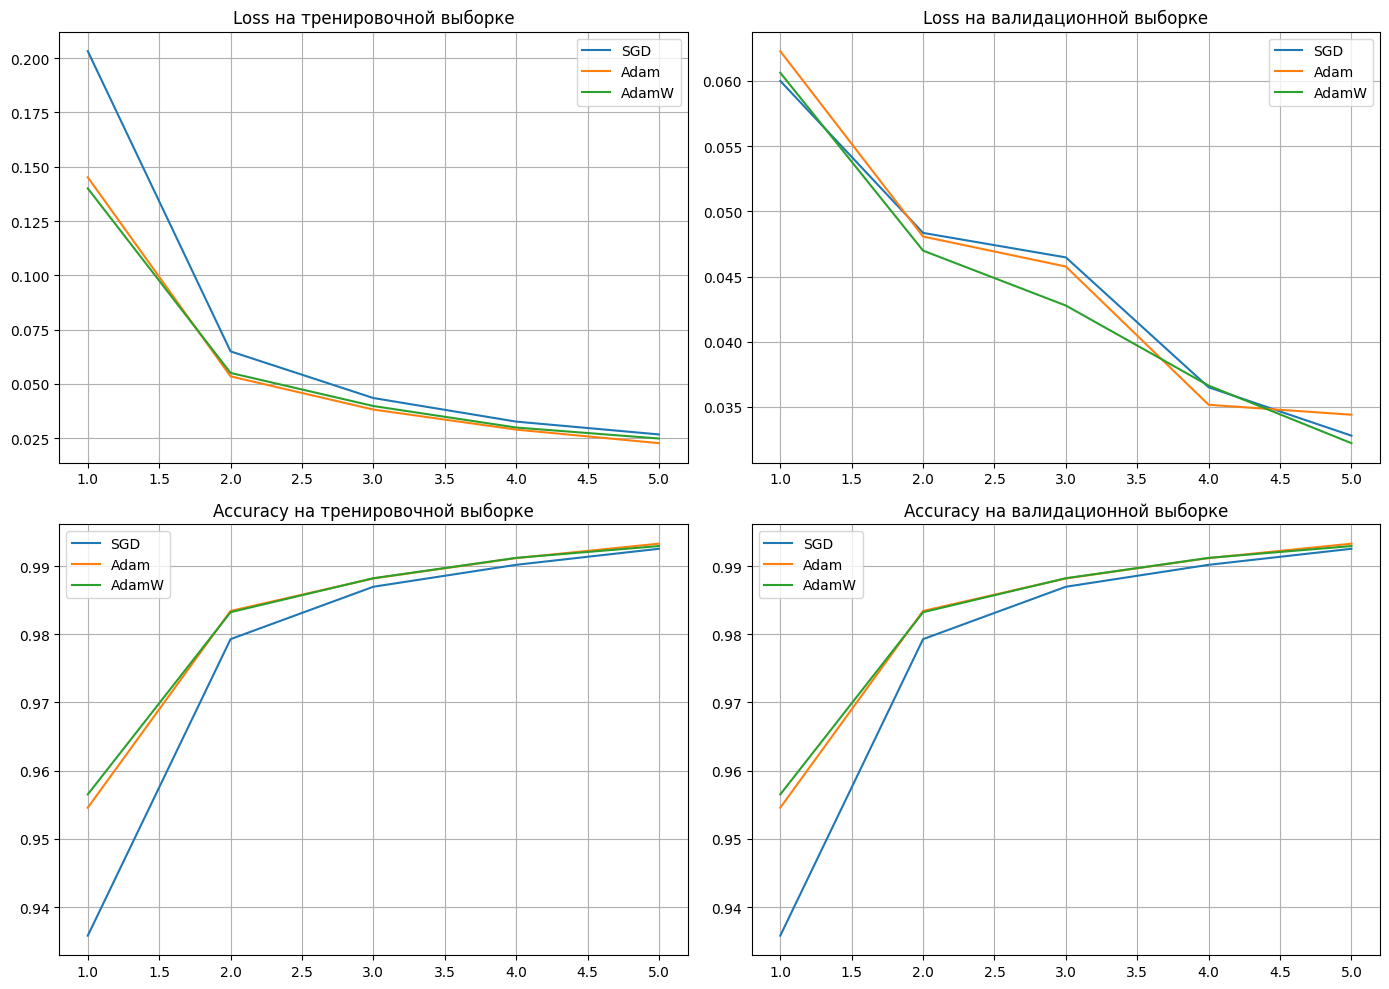

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs = np.arange(1, 5 + 1)

axes[0][0].plot(epochs, train_loss_list_SGD, label='SGD')
axes[0][0].plot(epochs, train_loss_list_Adam, label='Adam')
axes[0][0].plot(epochs, train_loss_list_AdamW, label='AdamW')
axes[0][0].set_title('Loss на тренировочной выборке')
axes[0][0].legend()
axes[0][0].grid()

axes[0][1].plot(epochs, val_loss_list_SGD, label='SGD')
axes[0][1].plot(epochs, val_loss_list_Adam, label='Adam')
axes[0][1].plot(epochs, val_loss_list_AdamW, label='AdamW')
axes[0][1].set_title('Loss на валидационной выборке')
axes[0][1].legend()
axes[0][1].grid()

axes[1][0].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][0].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][0].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][0].set_title('Accuracy на тренировочной выборке')
axes[1][0].legend()
axes[1][0].grid()

axes[1][1].plot(epochs, train_accuracy_list_SGD, label='SGD')
axes[1][1].plot(epochs, train_accuracy_list_Adam, label='Adam')
axes[1][1].plot(epochs, train_accuracy_list_AdamW, label='AdamW')
axes[1][1].set_title('Accuracy на валидационной выборке')
axes[1][1].legend()
axes[1][1].grid()

plt.tight_layout()
plt.show()

По сравнению с LinerarLR CosineAnnealing позволил добиться еще меньшего значения loss: (0.03499, 0.03581, 0.03376) против (0.03280, 0.03441, 0.03223) и немного большей точности во всех алгоритмах.

### Выводы



*   SGD оказался не хуже более сложных Adam и AdamW в рамках данной задачи даже с фиксированным lr.
*   LinearLR и CosineAnnealing позволили немного улучшить резульаты, причем CosineAnnealing превзошел LinearLR.
*   Лучший результат по loss: 0.03179 - SGD с фиксированным lr, по accuracy: 0.99 - AdamW с CosineAnnealing



#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Стоит сделать оговорку, что

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

это не эквивалентая реализация NAG, а просто попытка получить нечто лучшее, чем обычный momentum

Здесь вы можете оставить комментарии по лекции или семинару:

Мне показалось довольно поверхностым и непонятным объяснение про получение несмещенных оценок первого и второго моментов в Adam'е.

Также хотелось бы больше комментариев про устройство оптимизаторов в torch и более подробное объяснение рукописной реализации Optimizer и optimize_function.

В целом, информативная лекция и хорошая идея самостоятельной реализации классов из pytorch в практической части и дз, гораздо более понятным стал принцип работы многих объектов в pytorch. Домашние задания в свою очередь не требуют написания огромного количества кода, а больше направлены на то, чтобы разобраться в работе базовых вещей, что является большим плюсом.